In [1]:
# Install necessary libraries
!pip install xarray rasterio geopandas pandas numpy matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 19.7 MB/s eta 0:00:00


In [2]:

import xarray as xr

import geopandas as gpd
import pandas as pd
import numpy as np

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

chirps_file_path = '/content/drive/MyDrive/Manitoba_assignment/chirps-v2_monthly_africa_2.5.nc'

In [5]:

chirps_data = xr.open_dataset(chirps_file_path)
chirps_data

<xarray.Dataset>
Dimensions:    (time: 519, latitude: 320, longitude: 300)
Coordinates:
  * latitude   (latitude) float32 -39.87 -39.62 -39.37 ... 39.38 39.62 39.87
  * longitude  (longitude) float32 -19.88 -19.63 -19.38 ... 54.38 54.62 54.88
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2024-03-01
Data variables:
    precip     (time, latitude, longitude) float32 ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [6]:
chirps_data = xr.open_dataset(chirps_file_path)['precip']
chirps_data

<xarray.DataArray 'precip' (time: 519, latitude: 320, longitude: 300)>
[49824000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -39.87 -39.62 -39.37 ... 39.38 39.62 39.87
  * longitude  (longitude) float32 -19.88 -19.63 -19.38 ... 54.38 54.62 54.88
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2024-03-01
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [7]:

OND = [10, 11, 12]
MAM = [3, 4, 5]

In [8]:

def seasonal_stats(data, season):
    seasonal_data = data.sel(time=data['time.month'].isin(season))
    seasonal_mean = seasonal_data.groupby('time.year').mean('time')
    seasonal_avg = seasonal_mean.mean('year')
    seasonal_std = seasonal_mean.std('year')
    return seasonal_avg, seasonal_std


In [9]:

ond_avg, ond_std = seasonal_stats(chirps_data, OND)


mam_avg, mam_std = seasonal_stats(chirps_data, MAM)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


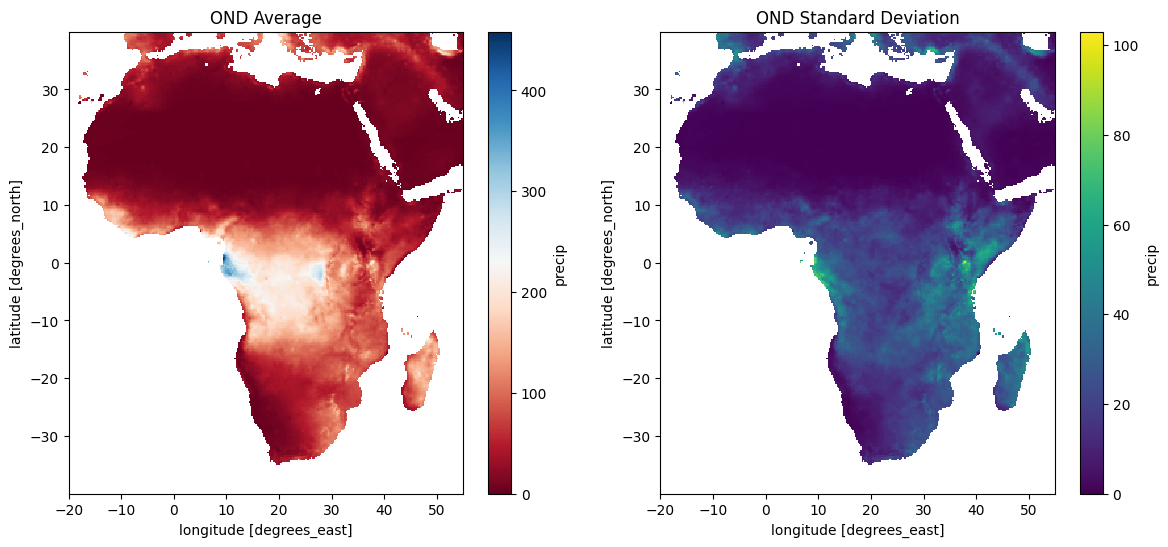

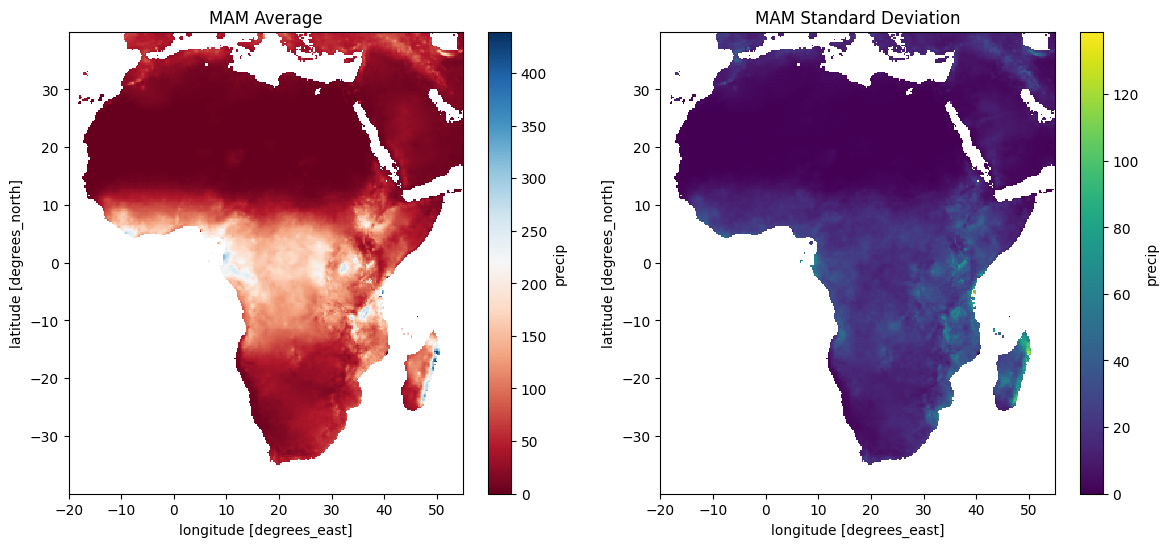

In [10]:
import matplotlib.pyplot as plt

def plot_seasonal_stats(avg, std, season_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    avg.plot(ax=axes[0], cmap='RdBu')
    axes[0].set_title(f'{season_name} Average')
    std.plot(ax=axes[1], cmap='viridis')
    axes[1].set_title(f'{season_name} Standard Deviation')
    plt.show()

plot_seasonal_stats(ond_avg, ond_std, 'OND')
plot_seasonal_stats(mam_avg, mam_std, 'MAM')

In [11]:

import scipy.stats as stats

def linear_trend(data, season, start_year, end_year):
    seasonal_data = data.sel(time=data['time.month'].isin(season))
    period_data = seasonal_data.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))
    period_mean = period_data.groupby('time.year').mean('time')


    years = period_mean['year']
    slopes = np.full(period_mean.isel(year=0).shape, np.nan)
    p_values = np.full(period_mean.isel(year=0).shape, np.nan)

    for i in range(period_mean.shape[1]):
        for j in range(period_mean.shape[2]):
            y = period_mean[:, i, j]
            if np.all(np.isnan(y)):
                continue
            slope, intercept, r_value, p_value, std_err = stats.linregress(years, y)
            slopes[i, j] = slope
            p_values[i, j] = p_value

    return slopes, p_values

In [12]:
# Calculate trends for 1980-2000 and 2000-2020
ond_trend_80_00, ond_pval_80_00 = linear_trend(chirps_data, OND, 1980, 2000)
ond_trend_00_20, ond_pval_00_20 = linear_trend(chirps_data, OND, 2000, 2020)
mam_trend_80_00, mam_pval_80_00 = linear_trend(chirps_data, MAM, 1980, 2000)
mam_trend_00_20, mam_pval_00_20 = linear_trend(chirps_data, MAM, 2000, 2020)

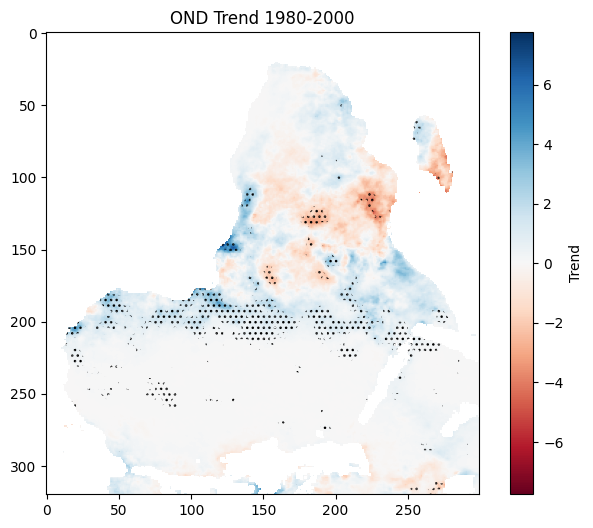

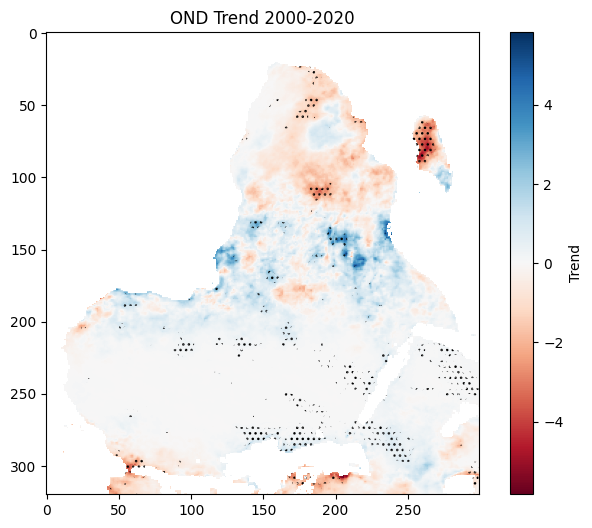

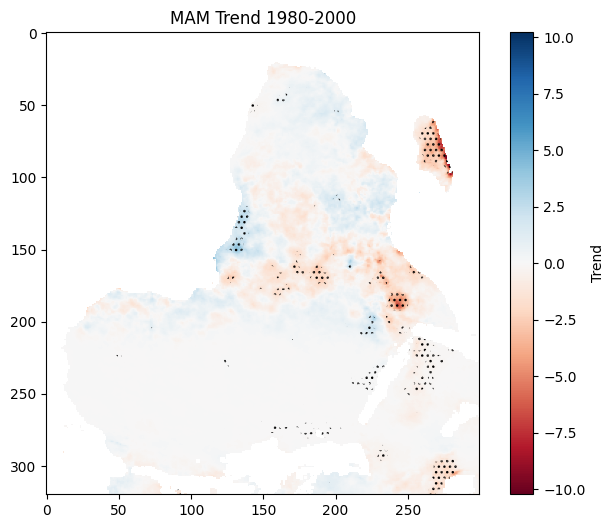

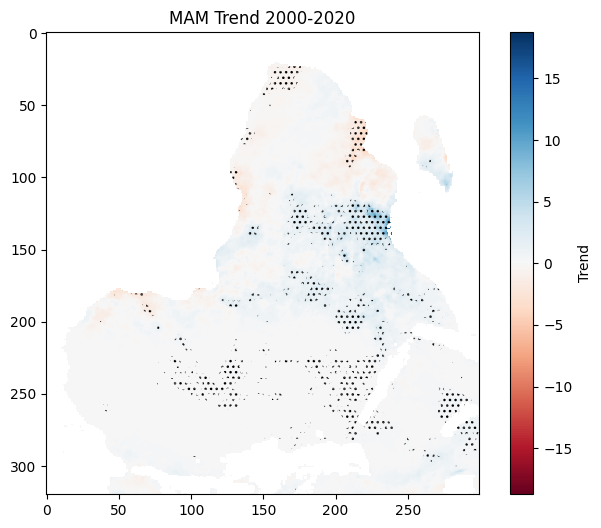

In [13]:
# Plot trends and mark statistically significant regions
def plot_trends(trend, pval, season_name, period):
    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.imshow(trend, cmap='RdBu', vmin=-np.nanmax(np.abs(trend)), vmax=np.nanmax(np.abs(trend)))
    plt.colorbar(c, ax=ax, label='Trend')
    ax.contourf(np.where(pval < 0.05, pval, np.nan), hatches=['...'], colors='none')
    ax.set_title(f'{season_name} Trend {period}')
    plt.show()

plot_trends(ond_trend_80_00, ond_pval_80_00, 'OND', '1980-2000')
plot_trends(ond_trend_00_20, ond_pval_00_20, 'OND', '2000-2020')
plot_trends(mam_trend_80_00, mam_pval_80_00, 'MAM', '1980-2000')
plot_trends(mam_trend_00_20, mam_pval_00_20, 'MAM', '2000-2020')